# A Population Model

This section introduces a simplified **population model** designed to illustrate how *ModelFlow* handles **cohort dynamics**, **age transitions**, and **causal dependencies**.

The model tracks population changes across age groups and sexes, incorporating key demographic processes such as:

- **Births** — introducing new individuals into the youngest cohort  
- **Deaths** — removing individuals from each age group based on age-specific mortality rates  
- **Migration** — adjusting population levels through net inflows or outflows  
- **Aging** — transferring individuals from one age group to the next over time  

Through automatic list expansion and dependency tracing, *ModelFlow* enables clear and compact equation definitions while maintaining full transparency of the underlying causal structure.

In [1]:
#from pprint import pprint
from IPython.display import display, Math, Latex, Markdown , Image, SVG, display_svg,IFrame    

from modelconstruct import Mexplode,mfmod_list_to_codeblock


In [2]:
%load_ext autoreload
%autoreload 2

## Derived sublists
To support **modeling of cohorts** and **debt/asset developments**, *ModelFlow* automatically creates a set of derived sublists based on an initial list definition.

For example, the statement:

> list ages = ages : age_0 * age_3

defines a base list and generates several auxiliary lists that make it easier to model age transitions and boundary conditions.

The following sublists become available:

| **Key**          | **Description / Interpretation**              | **Values**                 |
|------------------|-----------------------------------------------|----------------------------|
| `AGES`           | The base list of age variables                | `['AGE_0', 'AGE_1', 'AGE_2']` |
| `AGES_AFTER`     | Elements shifted one step forward (next age)  | `['AGE_1', 'AGE_2', '0']`     |
| `AGES_BEFORE`    | Elements shifted one step backward (previous age) | `['0', 'AGE_0', 'AGE_1']` |
| `AGES_END`       | Flag: 1 if last element, else 0               | `['0', '0', '1']`          |
| `AGES_MIDDLE`    | Flag: 1 if middle element(s), else 0          | `['0', '1', '0']`          |
| `AGES_NOEND`     | Flag: 1 if not the last element, else 0       | `['1', '1', '0']`          |
| `AGES_NOSTART`   | Flag: 1 if not the first element, else 0      | `['0', '1', '1']`          |
| `AGES_START`     | Flag: 1 if first element, else 0              | `['1', '0', '0']`          |


### Example usage

These derived lists can be used both for **shifting variables** across age or maturity groups and for **conditional equation generation**.

For instance, the statement below describes that the **population at the start of a year (`pop_primo`)** equals the **population in the same age group at the end of the previous year (`pop`)**, but **only for age groups that are not the first**:

```python
doable [ages ages_nostart]  pop_primo__{ages} = pop__{ages_before}
```

Here:

 - ages iterates over all defined age groups (AGE_0, AGE_1, AGE_2).

 - ages_nostart ensures that the equation is not applied to the first group (AGE_0).

 - ages_before provides the corresponding previous age ( AGE_1 → AGE_0, etc.).

This structure allows concise specification of interlinked cohort or maturity dynamics while automatically handling boundary conditions such as the first or last group.

In [3]:
Mexplode('''
>list ages = ages : age_0 * age_5
>doable [ages ages_nostart]  pop_primo__{ages} = pop__{ages_before}(-1)''').show

FRML <> POP_PRIMO__AGE_1 = POP__AGE_0(-1) $
FRML <> POP_PRIMO__AGE_2 = POP__AGE_1(-1) $
FRML <> POP_PRIMO__AGE_3 = POP__AGE_2(-1) $
FRML <> POP_PRIMO__AGE_4 = POP__AGE_3(-1) $


## Specification of a model describing population dynamics

Below, a small population model is defined.  
To make the specification more concise and readable, two string replacements are performed through the call to `Mexplode`.

The replacements are:

| **Placeholder** | **Replaced with**                         | **Description** |
|:------------------|:-------------------------------------------|:-----------------|
| `__ab`           | `__{sexes}__{ages_before}`                | Refers to the same sex but the previous age group |
| `__a`            | `__{sexes}__{ages}`                       | Refers to the same sex and the current age group |

This approach reduces visual clutter in the equation definitions and helps express structured relationships more clearly across **sex** and **age** dimensions.


In [4]:
eq = r'''
# A Demography Model — Detailed Explanation

This model describes the evolution of a population over time, divided by age groups and sex.
It captures the fundamental demographic dynamics — births, deaths, and migration — which together determine 
how the total population changes from one period to the next.

---

## 1. List Definitions

>list ages = ages : age_0 * age_11  
>list sexes = sexes   : female male /  
>             fertile :     1     0  

These lists define the model’s structural dimensions:

- "ages" enumerates age groups, from age_0 (newborns) up to age_11 (the oldest group).  
- "sexes" distinguishes between female and male.  
- The "fertile" flag marks whether a sex is fertile (1 for females, 0 for males), which determines participation in the fertility equations.

---

## 2. Population Dynamics

The population is tracked at various stages within each period.

### a. Primo Population

>doable [ages ages_nostart]  pop_primo__a = pop__ab(-1)

For all age groups except the youngest (`ages_nostart` excludes the start group),
the beginning-of-period (primo) population in an age group is equal to the end-of-period (ultimo) population of the previous age group in 
the previous period.
This represents aging: people move from one age group to the next as time progresses.

### b. Population Before Death

For the youngest age group:

>doable [ages ages_start]   pop_before_death__a   = birth__total__{sexes} + migration__a

The youngest group’s population before death depends on births of that sex in the current period and net migration for that age group.
This reflects that new members of the population come from births and migration, since there is no prior age group for newborns.

For all other age groups:

>doable [ages ages_nostart] pop_before_death__a   = pop_primo__a + migration__a

Older groups’ populations before death are determined by the primo population (those who aged into the group) and migration inflows or outflows.

---

## 3. Mortality and Deaths

>doable  [ages ages_end ]  death_rate__a =1.0  
>doable  <sum=total> death__a = pop_before_death__a  * death_rate__a

For the last age group, the death rate is set to 1.0, implying that everyone in this group dies within the period — 
a closure condition preventing population overflow beyond the oldest cohort.
Deaths in all groups are computed as the product of the population before death and the age-specific death rate.

## 4. End-of-Period (Ultimo) Population

>doable  <sum=total> pop__a  = pop_before_death__a  - death__a

The end-of-period population equals the population before death minus deaths.
This is the surviving population that will age into the next group in the following period.


## 5. Births and Fertility

>doable <sum=total> [ages ages_nostart,  sexes fertile] birth__a = pop_primo__a * fertility__a

Births are generated by fertile females in each age group.
Fertility rates (fertility__a) vary by age, and are in the dataframe set to zero outside reproductive ages.
The total number of births is thus the sum across fertile age groups.

---

## 6. Sex Ratio at Birth

>birth__total__female = FRAC_BIRTH__female * birth_total  
>birth__total__male = (1 - FRAC_BIRTH__female) * birth_total

The total births are split into female and male newborns using the fraction `FRAC_BIRTH__female`.
This ensures a biologically realistic sex distribution at birth.

---

## 7. Totals and Consistency Check

>migration__total = sum(ages,sum(sexes,migration__a))  
migration__total aggregates migration flows over all ages and sexes.

>pop__total_check  = (pop__total(-1) + birth__total + migration__total - death__total) - pop__total

pop__total_check serves as a consistency test for the model:
The change in total population should equal births + migration – deaths.
Any deviation indicates potential modeling or data inconsistencies.

---

## Summary

This demographic model captures the fundamental accounting identities of population dynamics:

Population<sub>t</sub><sup>age</sup> = Population<sub>t-1</sub><sup>age-1</sup> + Births<sub>t</sub><sup>age</sup> + Migration<sub>t</sub><sup>age</sup> - Deaths<sub>t</sub><sup>age</sup>

For the youngest cohort (age = 0), there is no inflow from age − 1,  
so the equation simplifies to:

Population<sub>t</sub><sup>0</sup> = Births<sub>t</sub> + Migration<sub>t</sub><sup>0</sup> - Deaths<sub>t</sub><sup>0</sup>

It distinguishes individuals by age and sex, allowing for realistic aging, fertility, and mortality processes.
The model is modular and extendable — one could add features such as:
- Age-dependent migration patterns
- Variable mortality shocks (for example, pandemics)
- Policy impacts on fertility rates
- Regional or socioeconomic subpopulations

'''
mm = Mexplode(eq,
replacements=[(r'__ab',r'__{sexes}__{ages_before}'),(r'__a',r'__{sexes}__{ages}')])

## From This Input:

In [5]:
mm.markdown_model


# A Demography Model — Detailed Explanation

This model describes the evolution of a population over time, divided by age groups and sex.
It captures the fundamental demographic dynamics — births, deaths, and migration — which together determine 
how the total population changes from one period to the next.

---

## 1. List Definitions

```text
>list ages = ages : age_0 * age_11  
>list sexes = sexes   : female male /  
>             fertile :     1     0  
```

These lists define the model’s structural dimensions:

- "ages" enumerates age groups, from age_0 (newborns) up to age_11 (the oldest group).  
- "sexes" distinguishes between female and male.  
- The "fertile" flag marks whether a sex is fertile (1 for females, 0 for males), which determines participation in the fertility equations.

---

## 2. Population Dynamics

The population is tracked at various stages within each period.

### a. Primo Population

```text
>doable [ages ages_nostart]  pop_primo__a = pop__ab(-1)
```

For all age groups except the youngest (`ages_nostart` excludes the start group),
the beginning-of-period (primo) population in an age group is equal to the end-of-period (ultimo) population of the previous age group in 
the previous period.
This represents aging: people move from one age group to the next as time progresses.

### b. Population Before Death

For the youngest age group:

```text
>doable [ages ages_start]   pop_before_death__a   = birth__total__{sexes} + migration__a
```

The youngest group’s population before death depends on births of that sex in the current period and net migration for that age group.
This reflects that new members of the population come from births and migration, since there is no prior age group for newborns.

For all other age groups:

```text
>doable [ages ages_nostart] pop_before_death__a   = pop_primo__a + migration__a
```

Older groups’ populations before death are determined by the primo population (those who aged into the group) and migration inflows or outflows.

---

## 3. Mortality and Deaths

```text
>doable  [ages ages_end ]  death_rate__a =1.0  
>doable  <sum=total> death__a = pop_before_death__a  * death_rate__a
```

For the last age group, the death rate is set to 1.0, implying that everyone in this group dies within the period — 
a closure condition preventing population overflow beyond the oldest cohort.
Deaths in all groups are computed as the product of the population before death and the age-specific death rate.

## 4. End-of-Period (Ultimo) Population

```text
>doable  <sum=total> pop__a  = pop_before_death__a  - death__a
```

The end-of-period population equals the population before death minus deaths.
This is the surviving population that will age into the next group in the following period.


## 5. Births and Fertility

```text
>doable <sum=total> [ages ages_nostart,  sexes fertile] birth__a = pop_primo__a * fertility__a
```

Births are generated by fertile females in each age group.
Fertility rates (fertility__a) vary by age, and are in the dataframe set to zero outside reproductive ages.
The total number of births is thus the sum across fertile age groups.

---

## 6. Sex Ratio at Birth

```text
>birth__total__female = FRAC_BIRTH__female * birth_total  
>birth__total__male = (1 - FRAC_BIRTH__female) * birth_total
```

The total births are split into female and male newborns using the fraction `FRAC_BIRTH__female`.
This ensures a biologically realistic sex distribution at birth.

---

## 7. Totals and Consistency Check

```text
>migration__total = sum(ages,sum(sexes,migration__a))  
```
migration__total aggregates migration flows over all ages and sexes.

```text
>pop__total_check  = (pop__total(-1) + birth__total + migration__total - death__total) - pop__total
```

pop__total_check serves as a consistency test for the model:
The change in total population should equal births + migration – deaths.
Any deviation indicates potential modeling or data inconsistencies.

---

## Summary

This demographic model captures the fundamental accounting identities of population dynamics:

Population<sub>t</sub><sup>age</sup> = Population<sub>t-1</sub><sup>age-1</sup> + Births<sub>t</sub><sup>age</sup> + Migration<sub>t</sub><sup>age</sup> - Deaths<sub>t</sub><sup>age</sup>

For the youngest cohort (age = 0), there is no inflow from age − 1,  
so the equation simplifies to:

Population<sub>t</sub><sup>0</sup> = Births<sub>t</sub> + Migration<sub>t</sub><sup>0</sup> - Deaths<sub>t</sub><sup>0</sup>

It distinguishes individuals by age and sex, allowing for realistic aging, fertility, and mortality processes.
The model is modular and extendable — one could add features such as:
- Age-dependent migration patterns
- Variable mortality shocks (for example, pandemics)
- Policy impacts on fertility rates
- Regional or socioeconomic subpopulations


## This high level model is extracted:

In [6]:
print(mm.clean_frml_statements)

LIST AGES =
    AGES : AGE_0 * AGE_11  $
LIST SEXES =
    SEXES   : FEMALE MALE /
    FERTILE : 1      0  $
DOABLE [AGES AGES_NOSTART]  POP_PRIMO__{SEXES}__{AGES} = POP__{SEXES}__{AGES_BEFORE}(-1)$
DOABLE [AGES AGES_START]   POP_BEFORE_DEATH__{SEXES}__{AGES}   = BIRTH__TOTAL__{SEXES} + MIGRATION__{SEXES}__{AGES}$
DOABLE [AGES AGES_NOSTART] POP_BEFORE_DEATH__{SEXES}__{AGES}   = POP_PRIMO__{SEXES}__{AGES} + MIGRATION__{SEXES}__{AGES}$
DOABLE  [AGES AGES_END ]  DEATH_RATE__{SEXES}__{AGES} =1.0  $
DOABLE  <SUM=TOTAL> DEATH__{SEXES}__{AGES} = POP_BEFORE_DEATH__{SEXES}__{AGES}  * DEATH_RATE__{SEXES}__{AGES}$
DOABLE  <SUM=TOTAL> POP__{SEXES}__{AGES}  = POP_BEFORE_DEATH__{SEXES}__{AGES}  - DEATH__{SEXES}__{AGES}$
DOABLE <SUM=TOTAL> [AGES AGES_NOSTART,  SEXES FERTILE] BIRTH__{SEXES}__{AGES} = POP_PRIMO__{SEXES}__{AGES} * FERTILITY__{SEXES}__{AGES}$
FRML  <> BIRTH__TOTAL__FEMALE = FRAC_BIRTH__FEMALE * BIRTH_TOTAL   $
FRML  <> BIRTH__TOTAL__MALE = (1 - FRAC_BIRTH__FEMALE) * BIRTH_TOTAL $
FRML  <>

## This low level model is generated:

In [7]:
mm.show

FRML <> POP_PRIMO__FEMALE__AGE_1 = POP__FEMALE__AGE_0(-1) $
FRML <> POP_PRIMO__FEMALE__AGE_2 = POP__FEMALE__AGE_1(-1) $
FRML <> POP_PRIMO__FEMALE__AGE_3 = POP__FEMALE__AGE_2(-1) $
FRML <> POP_PRIMO__FEMALE__AGE_4 = POP__FEMALE__AGE_3(-1) $
FRML <> POP_PRIMO__FEMALE__AGE_5 = POP__FEMALE__AGE_4(-1) $
FRML <> POP_PRIMO__FEMALE__AGE_6 = POP__FEMALE__AGE_5(-1) $
FRML <> POP_PRIMO__FEMALE__AGE_7 = POP__FEMALE__AGE_6(-1) $
FRML <> POP_PRIMO__FEMALE__AGE_8 = POP__FEMALE__AGE_7(-1) $
FRML <> POP_PRIMO__FEMALE__AGE_9 = POP__FEMALE__AGE_8(-1) $
FRML <> POP_PRIMO__FEMALE__AGE_10 = POP__FEMALE__AGE_9(-1) $
FRML <> POP_PRIMO__MALE__AGE_1 = POP__MALE__AGE_0(-1) $
FRML <> POP_PRIMO__MALE__AGE_2 = POP__MALE__AGE_1(-1) $
FRML <> POP_PRIMO__MALE__AGE_3 = POP__MALE__AGE_2(-1) $
FRML <> POP_PRIMO__MALE__AGE_4 = POP__MALE__AGE_3(-1) $
FRML <> POP_PRIMO__MALE__AGE_5 = POP__MALE__AGE_4(-1) $
FRML <> POP_PRIMO__MALE__AGE_6 = POP__MALE__AGE_5(-1) $
FRML <> POP_PRIMO__MALE__AGE_7 = POP__MALE__AGE_6(-1) $
FRML <>

## Tracing the causality structure

In the example below, the **causal chain** leading to the variable `POP__MALE__AGE_2` is traced upward through **8 dependency levels**.

>mm.mmodel.pop__male__age_2.tracepre(up=8, size=(10,10))   

This produces a causal dependency graph (as shown below), illustrating how upstream variables contribute to the population of 2-year-old males:

 - Blue boxes represent endogenous population and mortality variables.

 - Yellow boxes indicate exogenous , such as migration and death rates.

 - The red box highlights the target variable (POP__MALE__AGE_2).

The arrows show the flow of causality, moving from fundamental drivers like births, migration, and mortality rates toward the resulting population cohort.
This visualization helps understand how demographic processes propagate through the model and affect specific age groups.

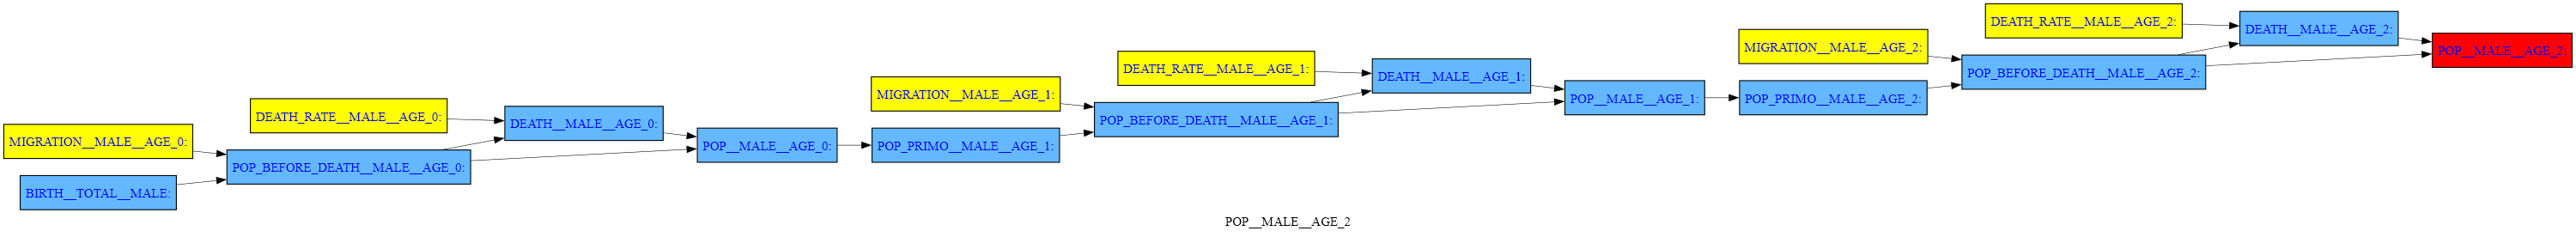

In [8]:
mm.mmodel.pop__male__age_2.tracepre(up=8,size=(10,10))